In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# Function to load and preprocess audio data by extracting features (MFCCs)
def load_and_preprocess_data(audio_path, label):
    # Load the audio file and set sample rate to None to keep it original
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC (Mel-frequency cepstral coefficients) features, often used in audio analysis
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose MFCCs to shape them correctly for model input
    return mfccs.T, label

# Function to prepare dataset from real and fake audio file paths
def prepare_dataset(real_paths, fake_paths):
    X, y = [], []  # X will hold features, y will hold labels (0 for real, 1 for fake)

    # Load real audio files and label them as 0 (real)
    for path in real_paths:
        features, label = load_and_preprocess_data(path, 0)
        X.append(features)
        y.append(label)

    # Load fake audio files and label them as 1 (fake)
    for path in fake_paths:
        features, label = load_and_preprocess_data(path, 1)
        X.append(features)
        y.append(label)

    # Return features (X) and labels (y) as numpy arrays for model compatibility
    return X, np.array(y)

In [3]:
def augment_data(X, y):
    augmented_X, augmented_y = [], []

    # Loop through each feature set and label
    for features, label in zip(X, y):
        augmented_X.append(features)  # Original features
        augmented_y.append(label)    # Original label

        # Time stretching (simulate by adjusting audio speed before extracting features)
        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

        # Pitch shifting (change pitch slightly for diversity in data)
        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050, n_steps=2)
        augmented_X.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

    # Return augmented features and labels
    return augmented_X, np.array(augmented_y)

In [4]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [5]:
# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    # Train the model and store the training history for plotting
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, verbose=1)

    # Evaluate the model on test data and print test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Return the training history to analyze learning progress
    return history

In [6]:
# Function to visualize training and validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [8]:
import os

In [9]:
base_path = "d:/SEE dataset/KAGGLE/AUDIO"

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.layers import Input, Masking

In [11]:
real_paths = [os.path.join(base_path, "REAL", f) for f in os.listdir(os.path.join(base_path, "REAL")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "FAKE", f) for f in os.listdir(os.path.join(base_path, "FAKE")) if f.endswith('.wav')]

# Prepare and augment the dataset
X, y = prepare_dataset(real_paths, fake_paths)
X_augmented, y_augmented = augment_data(X, y)

# Pad sequences
max_length = max([len(seq) for seq in X_augmented])
X_padded = pad_sequences(X_augmented, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_augmented, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create and train the model
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 916s 200s/step - accuracy: 0.3094 - loss: 0.7806 - val_accuracy: 0.6129 - val_loss: 0.6474
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 760s 190s/step - accuracy: 0.7640 - loss: 0.5978 - val_accuracy: 0.8710 - val_loss: 0.5312
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1077s 255s/step - accuracy: 0.9041 - loss: 0.4994 - val_accuracy: 0.8710 - val_loss: 0.4703
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 897s 219s/step - accuracy: 0.9041 - loss: 0.4401 - val_accuracy: 0.8710 - val_loss: 0.4196
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 965s 242s/step - accuracy: 0.8895 - loss: 0.3829 - val_accuracy: 0.8710 - val_loss: 0.3895
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1649s 426s/step - accuracy: 0.8978 - loss: 0.3572 - val_accuracy: 0.8710 - val_loss: 0.3778
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1072s 268s/step - accuracy: 0.9062 - loss: 0.3136 - val_accuracy: 0.8710 - val_loss: 0.3777
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1087s 270s/step - accuracy: 0.8614 - loss: 0.4093 - val_accuracy: 0.8710

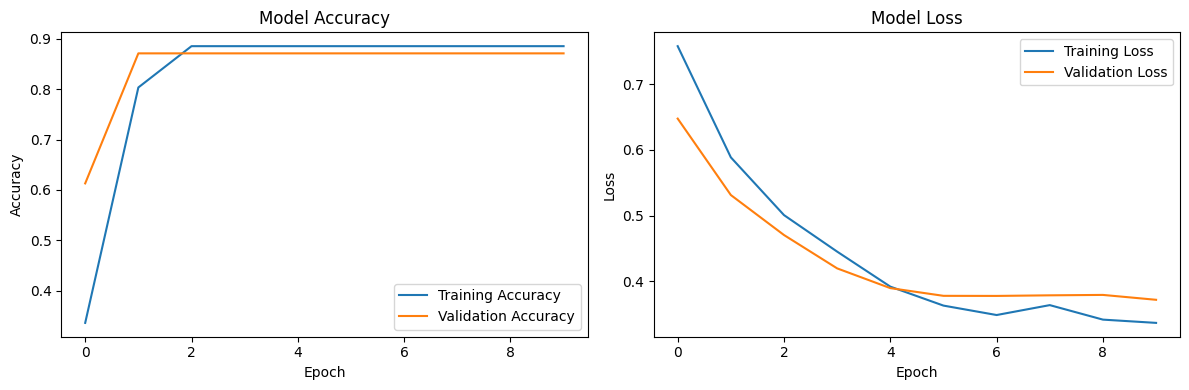

2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step


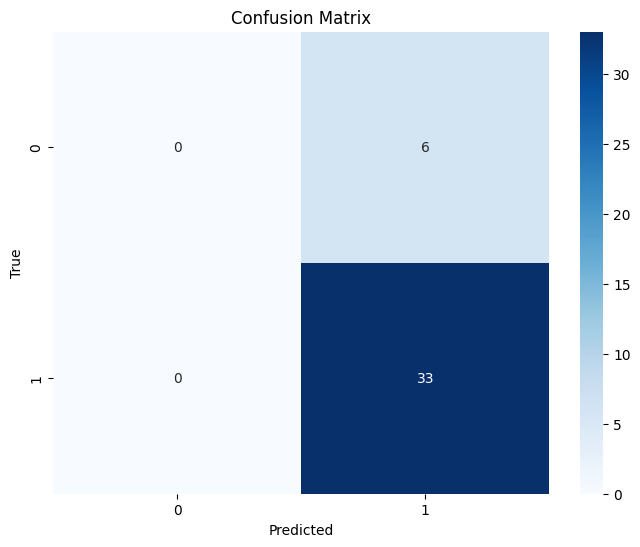

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.85      1.00      0.92        33

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39

Number of real audio samples: 8
Number of fake audio samples: 56
Total number of samples: 64
Shape of padded dataset: (192, 56293, 13)
Maximum sequence length: 56293
Shape of X_train: (153, 56293, 13)
Shape of X_test: (39, 56293, 13)


c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gchan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [12]:
# Visualize the results
plot_training_history(history)

y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

# Optional: Print dataset statistics
print(f"Number of real audio samples: {len(real_paths)}")
print(f"Number of fake audio samples: {len(fake_paths)}")
print(f"Total number of samples: {len(real_paths) + len(fake_paths)}")
print(f"Shape of padded dataset: {X_padded.shape}")
print(f"Maximum sequence length: {max_length}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

In [13]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_audio(audio_path, max_length):
    # Load the audio
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC features (use same parameters as training)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose the MFCCs to match the input format
    mfccs = mfccs.T

    # Pad the sequence to the max length used during training
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')

    return padded_mfccs

In [14]:
test_audio_paths = [r'D:\SEE dataset\KAGGLE\AUDIO\FAKE\linus-to-margot.wav']

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]

    if predicted_class == 1:
        print(f"{audio_path}: Fake")
    else:
        print(f"{audio_path}: Real")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
D:\SEE dataset\KAGGLE\AUDIO\FAKE\linus-to-margot.wav: Fake


In [15]:
model.save('audio_deepfake_detection_model.h5')